This is a test to try basic ML/AI technqiues for reverse image search.

This uses images that were scraped from a store.

This is the code will be using ecoding/decoding and KNN

In [ ]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")

C:\Users\mattb\AppData\Local\Temp/ipykernel_3916/499987355.py:9: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION, ImageFile


In [ ]:
class FolderDataset(Dataset):
    """
    Creates a PyTorch dataset from folder, returning two tensor images.
    Args: 
    main_dir : directory where images are stored.
    transform (optional) : torchvision transforms to be applied while making dataset
    """

    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [ ]:
class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        
        return x

In [ ]:
class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2), output_padding=(1,1))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2), output_padding=(1,0))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2), output_padding=(1,0))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.

        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)

        return x

In [ ]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    train_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    optimizer: PyTorch optimizer.
    device: "cuda" or "cpu"
    Returns: Train Loss
    """
    #  Set networks to train mode.
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        # Move images to device
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Zero grad the optimizer
        optimizer.zero_grad()
        # Feed the train images to encoder
        enc_output = encoder(train_img)
        # The output of encoder is input to decoder !
        dec_output = decoder(enc_output)
        
        # Decoder output is reconstructed image
        # Compute loss with it and orginal image which is target image.
        loss = loss_fn(dec_output, target_img)
        # Backpropogate
        loss.backward()
        # Apply the optimizer to network by calling step.
        optimizer.step()
    # Return the loss
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    val_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    device: "cuda" or "cpu"
    Returns: Validation Loss
    """
    
    # Set to eval mode.
    encoder.eval()
    decoder.eval()
    
    # We don't need to compute gradients while validating.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            # Move to device
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # Again as train. Feed encoder the train image.
            enc_output = encoder(train_img)
            # Decoder takes encoder output and reconstructs the image.
            dec_output = decoder(enc_output)
            
            # Validation loss for encoder and decoder.
            loss = loss_fn(dec_output, target_img)
    # Return the loss
    return loss.item()

In [ ]:
transforms = T.Compose([T.ToTensor(), T.Resize((506,400))]) # Normalize the pixels and convert to tensor.

full_dataset = FolderDataset("dataset", transforms) # Create folder dataset.
"""
train_size = int(len(full_dataset) * .75) # set train size to be 75% of dataset
val_size = len(full_dataset) - train_size # validate on 25%
"""
throw_away = int(len(full_dataset) * .85) # throwing away to increase training speed
train_size = int(len(full_dataset) * .10)
val_size = len(full_dataset) - train_size - throw_away # validate on 25%

# Split data to train and test
train_dataset, val_dataset, _ = torch.utils.data.random_split(full_dataset, [train_size, val_size, throw_away]) 


batch_size = 64
# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
 
# Create the validation dataloader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Create the full dataloader
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=32)

loss_fn = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = ConvEncoder() # Our encoder model
decoder = ConvDecoder() # Our decoder model


# Shift models to GPU
encoder.to(device)
decoder.to(device)

# Both the enocder and decoder parameters
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(autoencoder_params, lr=1e-3) # Adam Optimizer

# only two epochs to not fry my laptop
EPOCHS = 2
# Usual Training Loop
for epoch in tqdm(range(EPOCHS)):
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
        
        print(f"Epochs = {epoch}, Training Loss : {train_loss}")
        
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        
        print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

        print("Validation Loss decreased, saving new best model")
        #torch.save(encoder.state_dict(), "encoder_model.pt")
        #torch.save(decoder.state_dict(), "decoder_model.pt")


0it [00:00, ?it/s]


In [ ]:
encoder = ConvEncoder() # load encoder so we can test
encoder.load_state_dict(torch.load("encoder_model.pt"))
encoder.to(device)

ConvEncoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (maxpool5): MaxPool2d(kernel_size=(2, 2), stride=(2,

In [ ]:
# set up the encoder
encoder.eval()
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=128)
embedding = None
with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            train_img = train_img.to(device)
            
            enc_output = encoder(train_img).cpu()
            if embedding is None:
                embedding = enc_output
            else:
                embedding = torch.cat((embedding, enc_output), 0)

In [ ]:
# reshape the embedding flattening the laten space
embedding_single = embedding.reshape(6899,-1)

In [ ]:
url_to_embedding = {} # url to latent space
i = 0
for root, dirs, files in os.walk("./dataset", topdown=False):
    for name in files:
        url_to_embedding[name] = embedding_single[i].tolist()
        i += 1

In [ ]:
import json
with open('convert.txt', 'w') as convert_file:
     convert_file.write(json.dumps(url_to_embedding)) # save file as json to ensure that it can be used later as a standalone lookup table

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

values  = list(url_to_embedding.values())
url_outputs = list(url_to_embedding.keys())

neigh = KNeighborsClassifier(n_neighbors=10) # convert json to KNN useing sklearn
neigh.fit(values, url_outputs)

KNeighborsClassifier(n_neighbors=10)

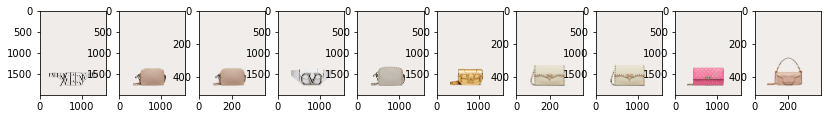

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt

#show images passed in
def show_images(images_url_index) -> None:
    n: int = len(images_url_index)
    f = plt.figure()
    f.set_size_inches(14, 6, forward=True)
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        img = mpimg.imread('dataset/'+url_outputs[images_url_index[i]])
        plt.imshow(img)

    plt.show(block=True)


#test with values to ensure they look ok (first image shown is input image as imput image is alway within the dataset)
distances, indexes = neigh.kneighbors([values[3400]], 10)

show_images(indexes[0])
